# BATDOG

### *The <font color=red>B</font>ayesian <font color=red>A</font>s<font color=red>t</font>rometric <font color=red>D</font>ust Cart<font color=red>og</font>rapher*

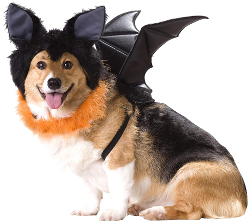

**A Python notebook for processing of parallaxes, comparison with variable star distances and inference of line of sight interstellar extinction to said variable stars.**

------

## Contents

#### 1. Imports/dependencies
#### 2. Loading of data
#### 3. Setup of likelihood & priors
#### 4. Running of emcee
#### 5. Data saving and plotting

------

# 1. Imports and dependencies

Specify directories

In [56]:
# Directory where we can find data for plotting
data_dir = 'data/'

Import packages

In [204]:
# Packages you probably have:
import numpy as np
from scipy.optimize import fmin  # for some data loading shiz
from scipy.stats import norm
import pandas as pd
import sys
import matplotlib.pyplot as plt
#import progressbar  # for timing MCMC running

# Packages you might not have:
import emcee
import corner  # for plots later

# Local .py files that should be in the same dir as this notebook:
# <none>

# 2. Loading of data

## Creation of PLR relation class
We define a PLR relation class with a number of useful methods. Each instance stores its own PLR parameters.

In [58]:
class PLR:
    # Dependencies
    import numpy as np
    
    def __init__(self):
        """Create a, b dictionaries local to each instance for storing 
        PLR parameters.
        """
        self.a = {}
        self.b = {} 
        
    def check_is_list(self, test):
        """Little function for making things lists if they aren't already."""
        if type(test) is not list or np.ndarray:
            return [test]
        else:
            return test
    
    def set_band(self, new_a, new_b, band='default'):
        """Sets the specified band. Defaults to setting it for a single 
        default band. It is entirely possible to pass a list of bands to 
        this method for easy assignment.
        """
        # Typecast inputs as lists if necessary so we can iterate over them
        band = self.check_is_list(band)
        new_a = self.check_is_list(new_a)
        new_b = self.check_is_list(new_b)
               
        # Iterate over input bands and set a, b.
        for a_band, a_new_a, a_new_b in zip(band, new_a, new_b):      
            self.a[a_band] = float(a_new_a)
            self.b[a_band] = float(a_new_b)
    
    def read_band_a(self, band='default'):
        """Reads the specified band a value back to the user."""
        return self.a[band]
    
    def read_band_b(self, band='default'):
        """Reads the specified band b value back to the user."""
        return self.b[band]
    
    def list_of_bands(self):
        """Returns a list of currently loaded bands in a.
        It is assumed that self.a and self.b will always have the same keys,
        at least for proper assignment with the class' set_band method.
        """
        return list(self.a.keys())
        
    # The following are applications of the Leavitt law.
    def magnitude(self, period, band='default'):
        """Returns the apparent magnitude of a variable given a period."""
        return self.a[band] * (np.log10(period) - 1) + self.b[band]
    
    def period(self, magnitude, band='default'):
        """Returns the period of a variable given an apparent magnitude."""
        return np.power(10, (magnitude - self.b[band]) / self.a[band] + 1)

## Setup of a fake distribution
Create a fake data distribution, fuck with it, and go from there.
Try to sample stars from a unifrom density:

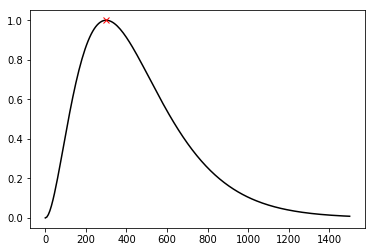

In [59]:
def true_parallax(r):
    """Returns what the exact true parallax should be in arcsecs for a given r."""
    return 1.0/r
    

def stellar_distribution(r, L, fact=1):
    """Returns pdf of a decreasing volume density distribution.
    L = scale length
    fact = in case we need the -ve of the function and as a factor too to normalise it
    """
    return fact/(2*L**3) * r**2 * np.exp(-r/L)


# Set some parameters
N = 20  # number of stars
N_bands = 1  # number of bands
scale = 150  # scale factor in pc to apply, roughly half the mode of the pdf

# Work out the maximum of our distribution
pdf_max_x = fmin(stellar_distribution, scale*2, args=(scale, -1), disp=False)
pdf_max_y = stellar_distribution(pdf_max_x, scale)

# Normalise the distribution to have its max at 1 for sampling
factor = 1.0 / pdf_max_y 

# Quick test of the distribution
hi = np.linspace(0, scale*10, num=200)
plt.plot(hi, stellar_distribution(hi, scale, fact=factor), 'k-')
plt.plot([pdf_max_x], stellar_distribution(pdf_max_x, scale, fact=factor), 'rx')
plt.show()

Let's sample the real location of the stars

In [60]:
# Some bits of setup of objects
rng = np.random.RandomState(42)  # Use a defined start number for repeatability
sampled_ids = pd.Series(list(range(0, N)))
data = pd.DataFrame(sampled_ids, columns=['ID'])  # Everything we care about will be in here

# Assign a random ra and dec to every star
data['ra'] = pd.Series(np.random.rand(N) * 360)
data['dec'] = pd.Series((np.random.rand(N) - 0.5)*180)

# Sample the pdf to get good values for r
i = 0
r_true = np.zeros(N)
while i < N:
    # Create a test r of size 13 times that of the scale and a deviate test_p to cf with the interval
    test_r = np.random.rand() * scale * 13
    test_p = np.random.rand()
    
    # See if the test point is in the distribution or not
    if test_p < stellar_distribution(test_r, scale, fact=factor):
        r_true[i] = test_r
        i += 1

# Assign the r values we've got to the data frame
data['r_true'] = pd.Series(r_true)
data['omega_true'] = pd.Series((1 / r_true)*1e3)

## Assigning stellar parameters to the distribution
Let's make two PL relations to use; a real one and an experimentally derived one.

In [61]:
real_PLR = PLR()
real_PLR.set_band(-2.7, 3.0)

test_PLR = PLR()
test_PLR.set_band(-2.75, 3.1)

Use the PL relation to infer values for things like magnitude and luminosity.

In [62]:
# Make up some stuff
# data['stellar_r_true'] = pd.Series((2-0.1)*np.random.rand(N) + 0.1)
data['P_true'] = pd.Series((20-5)*np.random.rand(N) + 5)
data['M_true'] = pd.Series(real_PLR.magnitude(data['P_true']))
data['m_true'] = pd.Series(data['M_true'] + 5*np.log10(data['r_true'] / 10))
data['A_true'] = pd.Series((2-0.1)*np.random.rand(N) + 0.1)

## Sampling experimental values

Now, let's sample some experimental values. **TODO: define an $r^2e^{-r}$ function to act as a model of the distribution of fractional errors on parameters:**

In [63]:
def error_distribution(value, max_error, min_error):
    """Currently just pulls out a random number *roughly* between max_error and min_error."""
    random_numbers = np.random.rand(value.size) * (max_error - min_error) + min_error
    return value * random_numbers

Next, we want to mess with all of our true values and generate some experimental ones to play with.

In [64]:
# to get deviates, do something like:
# (1 + a_gaussian_deviate(mean=0, s=something)) * true_value
# equivalent to:
# a_gaussian_deviate(mean=1, s=something) * true_value

# Setup some experimental values. 
# Currently, errors on experimental values are just the actual real ones but slightly messed with.
rng = np.random.RandomState(142)  # Use a defined start number for repeatability

# Parallax
parallax_errors = (data['omega_true'] 
                   * np.random.normal(loc=0, scale=0.4, size=N))
data['omega_exp'] = data['omega_true'] + parallax_errors
data['omega_sigma'] = np.abs(parallax_errors) + 0.2  # the extra 0.2 is to make sure no error bars are zero
                                         
# Apparent magnitude (uncorrected for extinction) and extinction estimates
app_magnitude_errors = (data['m_true'] 
                        * np.random.normal(loc=0, scale=0.01, size=N))
data['m_exp'] = data['m_true'] + app_magnitude_errors + data['A_true']
data['m_sigma'] = np.abs(app_magnitude_errors) + 0.1
data['A_exp'] = data['A_true'] * (0.9-0.6)*np.random.rand(N) + 0.6
data['A_sigma'] = 0.05 * data['A_exp']

# Period
period_errors = data['P_true'] * np.random.normal(loc=0, scale=0.1, size=N)
data['P_exp'] = data['P_true'] + period_errors
data['P_sigma'] = np.abs(period_errors) + 0.1

# Inferred absolute magniture from the test PLR
### THIS CURRENTLY JUST USES INPUT ERROR - needs knowledge of relationship error also
data['M_exp'] = pd.Series(test_PLR.magnitude(data['P_exp']))
data['M_exp_l'] = pd.Series(test_PLR.magnitude(data['P_exp'] 
                                               + data['P_sigma']))
data['M_exp_u'] = pd.Series(test_PLR.magnitude(data['P_exp'] 
                                               - data['P_sigma']))

# Inferred radii from the test PLR
data['r_exp'] = np.power(10, (data['m_exp'] 
                              - data['M_exp']) / 5 + 1)
data['r_exp_u'] = np.power(10, (data['m_exp'] + data['m_sigma']
                                - data['M_exp_l']) / 5 + 1)
data['r_exp_l'] = np.power(10, (data['m_exp'] - data['m_sigma']
                                - data['M_exp_u']) / 5 + 1)

# 3. Setup of likelihood & priors
**N.B. everything here is returning the result of a log.**

## Priors
#### On $\vec{A_k}$ (the extinction co-efficient in every band for star $k$)
This is simply a uniform prior to constrain the extinction co-efficient to something reasonable.

In [65]:
def prior_extinction(params, r):
    """Currently, a uniform prior between a reasonable range for an 
    extinction co-efficient."""
    # Constants
    max_extinction = 5
    min_extinction = 0
    
    # Set any incorrect range extinctions to -np.inf (log of 0) and return A
    return np.where(np.logical_or(params[r['A']] < min_extinction, 
                                  params[r['A']] > max_extinction), 
                    -np.inf, 0)

#### Prior on parallax
*Parallax is extremely dangerous. We must deal with it!* The following computes the parallax prior, which is effectively our distance prior but flipped around a bit.

In [66]:
def prior_parallax(params, r):
    """The distance prior but in terms of parallax. We check for any cheeky 
    parallaxes less than zero and set them to -np.inf - if not, set to 
    distance prior.
    """
    return np.where(params[r['omega']] < 0, -np.inf, 
                    np.log(1 / (2 * params[r['L']]**3 * params[r['omega']]**2)) 
                    - 1 / (params[r['omega']] * params[r['L']]))

## Likelihood function
Parts of the likelihood fn are defined here.

#### Likelihood of parallax data

In [67]:
def likelihood_parallax(params, r, data):
    """Returns a normal distribution evaluated at the measured Gaia parallax 
    value, with:
    
    mean = the inferred parallax value plus the Gaia zero-point offset
    standard deviation = the error on the Gaia parallax value
    """
    return np.log(norm(params[r['omega']] + params[r['omega_0']], 
                       data['omega_sigma']).pdf(data['omega_exp']))

#### Likelihood of absolute magnitude data

In [68]:
def likelihood_abs_mag(params, r, data):
    """This currently assumes the absolute magnitude is normally distributed.
    IT IS NOT.
    This should be changed later :)
    """
    return np.log(norm(params[r['M']], data['M_exp_u'] 
                - data['M_exp']).pdf(data['M_exp']))

#### Likelihood of apparent magnitude data

In [75]:
def likelihood_app_mag(params, r, data):
    """This currently assumes the apparent magnitude is normally distributed.
    IT IS NOT.
    This should be changed later :)
    """
    
    distribution = norm(params[r['M']] + params[r['A']] + 10 - 5 
                         * np.log10(params[r['omega']])
                         , data['m_sigma']).pdf(np.array(data['m_exp']))
    
    
    
    answer = np.log(distribution)
    
    """
    print("data mags: {}".format(np.array(data['m_exp'])))
    print("mags: {}".format(params[r['M']]))
    print("exts: {}".format(params[r['A']]))
    print("log om: {}".format(np.log10(params[r['omega']])))
    print("\ninput: {}".format(params[r['M']] + params[r['A']] + 10 - 5 
                             * np.log10(params[r['omega']])))
    print("dist: {}".format(distribution))
    print("answer: " + str(answer))
    """
    
    return answer

#### Probability of the nuisance magnitude parameters

In [196]:
def likelihood_nuisance(params, r):
    """Currently just a test that both the apparent and absolute magnitudes
    are within reasonable ranges.
    """
    # Constants
    max_M = 0.2
    min_M = 8
    max_m = 7
    min_m = 20
    
    # Test apparent and absolute magnitudes
    test_M = np.logical_or(params[r['M']] < max_M, params[r['M']] > min_M)
    test_m = np.logical_or(params[r['m']] < max_m, params[r['m']] > min_m)
    
    return np.where(np.logical_or(test_M, test_m), -np.inf, 0)

#### Logarithmic combination of all the above

In [154]:
def likelihood_total(params, ranges, data):
    """Sums all of the likelihood functions. Convenience function!"""
    return np.sum(likelihood_parallax(params, ranges, data) 
                  + likelihood_abs_mag(params, ranges, data) 
                  + likelihood_app_mag(params, ranges, data)
                  + likelihood_nuisance(params, ranges))

## Posterior
The last prep step! This function defines our log posterior.

In [155]:
def posterior(params, data, ranges):
    """Sums all of the logarithmic likelihoods and priors."""
    return np.sum(likelihood_total(params, ranges, data) 
                  + prior_extinction(params, ranges) 
                  + prior_parallax(params, ranges))

# 4. Running of emcee
The game is on! Everything is set up for us to run an mcmc simulation. First, some setup of some plotting help functions:

In [225]:
def plot_chains(sampler, star=0, start=False):
    """Plots the current stored chain output for a given star."""
    names = list(ranges.keys())
    
    # Gets the requisite parameter numbers for a given star
    values = [ranges['omega'][0] + star, ranges['omega_0'], ranges['L'], 
              ranges['A'][0] + star, ranges['m'][0] + star, ranges['M'][0] + star]
    
    # Check if the user specified a start point to plot from
    if start != False:
        s = start
    else:
        s = 0
    
    fig, ax = plt.subplots(7, figsize=(8, 10), sharex=True)

    # Plots likelihood
    ax[0].plot(sampler.lnprobability.T, '-r', alpha=0.2)
    ax[0].set_ylabel('lnprob')

    # Plots parameter evolution
    j=0  # Parameter to try
    for i in values:
        ax[j+1].plot(sampler.chain[:, s:, values[j]].T, '-k', alpha=0.2);
        ax[j+1].set_ylabel(names[j])
        j += 1
    plt.show()
        
def plot_corner(sampler, star=0, start=False):
    """Makes a corner plot using corner.py."""
    names = list(ranges.keys())
    values = [ranges['omega'][0] + star, ranges['omega_0'], ranges['L'], 
              ranges['A'][0] + star, ranges['m'][0] + star, ranges['M'][0] + star]
    
    # Check if the user specified a start point to plot from
    if start != False:
        s = start
    else:
        s = 0
    
    # Make a corner plot
    corner.corner(sampler.flatchain[:, values], labels=names, truths=starting_guess);
    plt.show()

Next, setup our starting guesses:

In [205]:
#------10|-------20|-------30|-------40|-------50|-------60|-------70|------79|xxxxxxxxx

# Define ranges that will be where data is stored in the overall
# mcmc position vector.
ranges = {'omega':list(range(0,N)),
          'omega_0':N,
          'L':N+1,
          'A':list(range(N+2, N+2 + 1*N*N_bands)),
          'm':list(range(N+2 + 1*N*N_bands, N+2 + 2*N*N_bands)),
          'M':list(range(N+2 + 2*N*N_bands, N+2 + 3*N*N_bands))}

# Some parameters for the MCMC simulation
dimensions = N + 2 + 3*N*N_bands
walkers = 164

# Make starting guesses on all of the parameters.
starting_guess = np.where(data['omega_exp']>0.0, data['omega_exp'], 0.001)
starting_guess = np.append(starting_guess, 0.0)  # omega 0
starting_guess = np.append(starting_guess, 150.0)  # L
starting_guess = np.append(starting_guess, data['A_exp'])
starting_guess = np.append(starting_guess, data['m_exp'])
starting_guess = np.append(starting_guess, data['M_exp'])

# Extend the starting guess to our number of walkers' dimensions
rng = np.random.RandomState(42)
starting_guesses = starting_guess + 0.0001 * rng.randn(walkers, dimensions)  # SHOULD MULTIPLY BY THE DESIRED RANGE OF PARAMS

Define a function to run emcee for us, providing status updates and **TODO: estimating autocorrelation.**

In [294]:
def run_emcee_for_me(sampler, steps=100, reset=False, guess=None, step_increment=10):
    """Auto-runs emcee, giving an update on each step done and estimating runtime."""    
    # See if we need to start from a guess
    if guess == None:
        # Set to last sampler position
        last_pos = sampler.chain[:, -1, :]
    else:
        # Set to the guess
        last_pos = guess
        
    # Wipe the sampler's memory if required
    if reset == True:
        sampler.reset()
    
    # A bit of start output
    sys.stdout.write("BATDOG is running!\n  steps={}\n\n".format(steps))
    sys.stdout.flush()
    
    # Loop until we reach steps
    current_step = 1
    while current_step <= steps:
        last_pos, last_prob, last_state = sampler.run_mcmc(last_pos, step_increment)
        sys.stdout.write("\rDone {} steps. ETA: {}".format(current_step, "W.I.P."))
        sys.stdout.flush()
        current_step += step_increment
    
    # Add a blank line at the end
    sys.stdout.write("\r                                 ")
    sys.stdout.flush()

Run mcmc

In [257]:
# Define the sampler
sampler = emcee.EnsembleSampler(walkers, dimensions, posterior, args=(data, ranges), threads=8)
sampler.random_state = rng

# time and run the MCMC
#%time pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

%time run_emcee_for_me(sampler, steps=100, guess=starting_guesses)

BATDOG is running!
  steps=100

                                 CPU times: user 4.64 s, sys: 180 ms, total: 4.82 s
Wall time: 12.6 s
emcee: Exception while calling your likelihood function:
  params: False
  args: (    ID          ra        dec       r_true  omega_true     P_true    M_true  \
0    0  215.922229 -18.029003  1108.827118    0.901854   5.990017  3.600944   
1    1  214.086598 -21.051716   701.143650    1.426241  16.927732  2.382783   
2    2  278.388765 -72.690695   226.225630    4.420366  19.947450  2.190304   
3    3  107.929662 -17.556972   359.249618    2.783580  12.790200  2.711431   
4    4  229.707946  77.996940   290.099540    3.447093  14.429954  2.569985   
5    5  272.880051  43.578951   257.815421    3.878744  14.832521  2.537720   
6    6   95.687431 -27.299204   207.861600    4.810893  14.572422  2.558464   
7    7  312.746807 -31.198920   432.099005    2.314284  18.272504  2.293145   
8    8    6.124956  82.020017   152.795965    6.544675  16.458676  2.4157

Traceback (most recent call last):
  File "/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-155-eabbc177fd1d>", line 5, in posterior
    + prior_parallax(params, ranges))
  File "<ipython-input-154-141d9ef47f01>", line 6, in likelihood_total
    + likelihood_nuisance(params, ranges))
  File "<ipython-input-67-0b7e4640444f>", line 8, in likelihood_parallax
    return np.log(norm(params[r['omega']] + params[r['omega_0']],
IndexError: invalid index to scalar variable.


emcee: Exception while calling your likelihood function:
  params: False
  args: (    ID          ra        dec       r_true  omega_true     P_true    M_true  \
0    0  215.922229 -18.029003  1108.827118    0.901854   5.990017  3.600944   
1    1  214.086598 -21.051716   701.143650    1.426241  16.927732  2.382783   
2    2  278.388765 -72.690695   226.225630    4.420366  19.947450  2.190304   
3    3  107.929662 -17.556972   359.249618    2.783580  12.790200  2.711431   
4    4  229.707946  77.996940   290.099540    3.447093  14.429954  2.569985   
5    5  272.880051  43.578951   257.815421    3.878744  14.832521  2.537720   
6    6   95.687431 -27.299204   207.861600    4.810893  14.572422  2.558464   
7    7  312.746807 -31.198920   432.099005    2.314284  18.272504  2.293145   
8    8    6.124956  82.020017   152.795965    6.544675  16.458676  2.415734   
9    9  224.755767  -3.386575   601.353003    1.662917  10.828335  2.906683   
10  10   58.128735  -2.236243   154.749301    6.4

Traceback (most recent call last):
  File "/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-155-eabbc177fd1d>", line 5, in posterior
    + prior_parallax(params, ranges))
  File "<ipython-input-154-141d9ef47f01>", line 6, in likelihood_total
    + likelihood_nuisance(params, ranges))
  File "<ipython-input-67-0b7e4640444f>", line 8, in likelihood_parallax
    return np.log(norm(params[r['omega']] + params[r['omega_0']],
IndexError: invalid index to scalar variable.


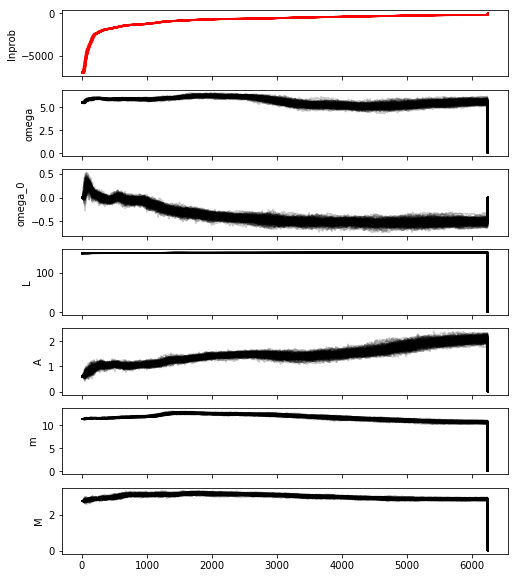

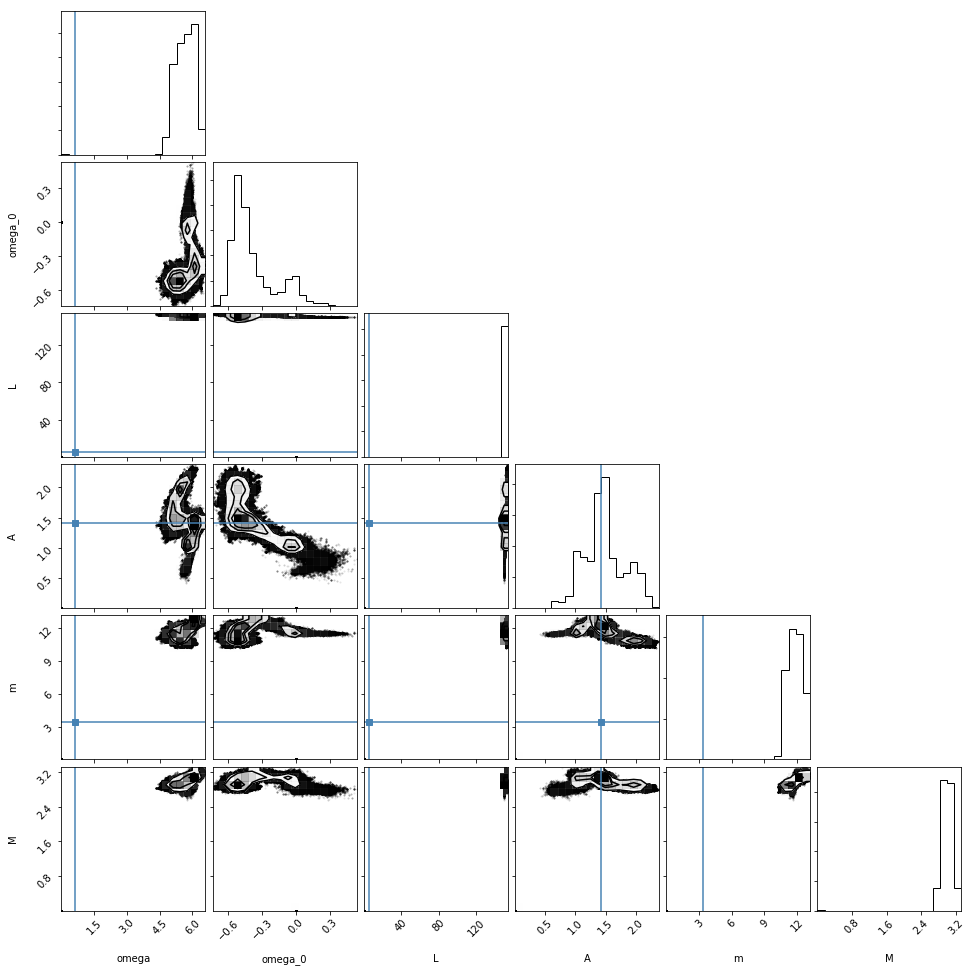

In [304]:
# Plot chains output
plot_chains(sampler, star=5)

# Make a corner plot
plot_corner(sampler, star=5, start=4000)

In [299]:
%time run_emcee_for_me(sampler, steps=10000)

BATDOG is running!
  steps=10000

Done 4931 steps. ETA: W.I.P.

KeyboardInterrupt: 

In [302]:
# Get data on star 5
data.iloc[[5]]

,ID,ra,dec,r_true,omega_true,P_true,M_true,m_true,A_true,omega_exp,...,A_exp,A_sigma,P_exp,P_sigma,M_exp,M_exp_l,M_exp_u,r_exp,r_exp_u,r_exp_l
5,5,272.880051,43.578951,257.815421,3.878744,14.832521,2.53772,9.594264,1.718363,5.510091,...,0.603849,0.030192,13.49644,1.436081,2.741897,2.621134,2.876259,538.010761,618.8545,464.807977


# 5. Data saving and plotting
First, outline a way to convert back from the emcee format to a format for easy output and comparison.